# TensorFlow

## Tensores

Los objetos fundamentales en TensorFlow son **tensores** (arreglos de varias dimensiones).

In [2]:
import tensorflow as tf

2023-09-05 23:15:13.969940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 23:15:22.632843: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])

2023-09-05 23:15:31.301197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 23:15:31.608771: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
print(x)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)


In [5]:
print(x.shape)

(2, 3)


In [6]:
print(x.dtype)

<dtype: 'float32'>


In [7]:
x+x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [8]:
5*x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 5., 10., 15.],
       [20., 25., 30.]], dtype=float32)>

In [9]:
x @ tf.transpose(x) #multiplicación de matrices

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [10]:
tf.concat([x, x, x], axis=0)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [11]:
tf.nn.softmax(x, axis=-1) #axis=-1 corresponde al último eje

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.09003057, 0.24472848, 0.66524094],
       [0.09003057, 0.24472848, 0.66524094]], dtype=float32)>

In [12]:
tf.reduce_sum(x)

<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

In [13]:
tf.convert_to_tensor([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

Se puede configurar TensorFlow para usar el GPU... Los cálculos de matrices corren mucho más rápidamente en un GPU (ver el curso Programación GPU de la Mención en CC!)

## Variables

Un objecto de tipo `tf.Tensor` es **inmutable** (no se puede modificar). Para guardar valores que cambiarán (los pesos de una red neuronal, por ejemplo) usamos `tf.Variable`.

In [14]:
var = tf.Variable([0.0, 0.0, 0.0])

In [15]:
var.assign([1, 2, 3])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [16]:
var.assign_add([1, 1, 1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

## Derivación automática (autodiff)

In [17]:
x = tf.Variable(1.0)

In [18]:
def f(x):
    y = x**2 + 2*x - 5
    return y

In [19]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

La derivada es $f'(x) = 2x+2$ entonces $f(1) = 4$.

In [20]:
with tf.GradientTape() as tape:
    y = f(x)

In [21]:
g_x = tape.gradient(y, x)

In [22]:
g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

## Gráfos y `tf.function`

TensorFlow incluye herramientas para:

* Optimizar el código: para acelerar cálculos
* Exportar: se puede guardar el modelo después de su entrenamiento, incluso para desplegar en un teléfono

Para usar estas capacidades, hay que ocupar `tf.function` para separar el código de TensorFlow (C++) del código de Python.

In [23]:
@tf.function
def mi_func(x):
    print('Corriendo la función...\n')
    return tf.reduce_sum(x)

Cuando corremos esa función, aunque ejecuta en Python, capta un gráfo completo y optimizado que representa los cálculos realizados por TensorFlow.

In [24]:
x = tf.constant([1, 2, 3])

In [25]:
mi_func(x)

Corriendo la función...



<tf.Tensor: shape=(), dtype=int32, numpy=6>

En llamadas subsiguientes solamente ejecutamos el gráfo optimizado de TensorFlow, saltando cualquier parte de Python puro.

In [26]:
x = tf.constant([10, 9, 8])

In [27]:
mi_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=27>

Si cambiamos la *signatura* de la función (usando un tensor con otro `shape` y/o `dtype`) tendrá que generar el gráfo de nuevo.

In [28]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)

In [29]:
mi_func(x)

Corriendo la función...



<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

Con estos gráfos podemos:

* Acelerar la ejecución del cálculo.
* Exportar el gráfo, con `tf.saved_model` para ejecutar el modelo en otro sistema, sin la necesidad de una instalación de Python.

## Módulos, capas y modelos

`tf.Module` es una clase para gestionar los objetos `tf.Variable` y las funciones de tipo `tf.function` que operan es ellos. Es necesaria para:

1. Guardar y restaurar valores de las variables con `tf.train.Checkpoint`. Por ejemplo, si el tiempo de entrenamiento es muy grande.

2. Importar y exportar los valores de `tf.Variable` y los gráfos de `tf.function` con `tf.saved_model`.

In [30]:
class MiModulo(tf.Module):
    def __init__(self, valor):
        self.peso = tf.Variable(valor)
        
    @tf.function
    def multiplicar(self, x):
        return x * self.peso

In [31]:
mod = MiModulo(3)

In [32]:
mod.multiplicar(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

In [33]:
ruta_guardar = './guardado'

In [34]:
tf.saved_model.save(mod, ruta_guardar)

INFO:tensorflow:Assets written to: ./guardado/assets


El *SavedModel* es independiente del código usado para crearlo. Se puede cargar un *SavedModel* en Python, otros lenguajes, <span style="color:blue">TensorFlow Serving</span> (para una página web), <span style="color:blue">TensorFlow Lite</span> (para un teléfono), o <span style="color:blue">TensorFlow JS</span> (para algo que corre directamente en el navegador).

In [35]:
reloaded = tf.saved_model.load(ruta_guardar)

In [36]:
reloaded.multiplicar(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

## Ciclo de entrenamiento

Ahora vamos a crear y entrenar un modelo usando TensorFlow

In [37]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

In [38]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

In [39]:
def f(x):
    y = x**2 + 2*x - 5
    return y

In [40]:
y = f(x) + tf.random.normal(shape=[201])

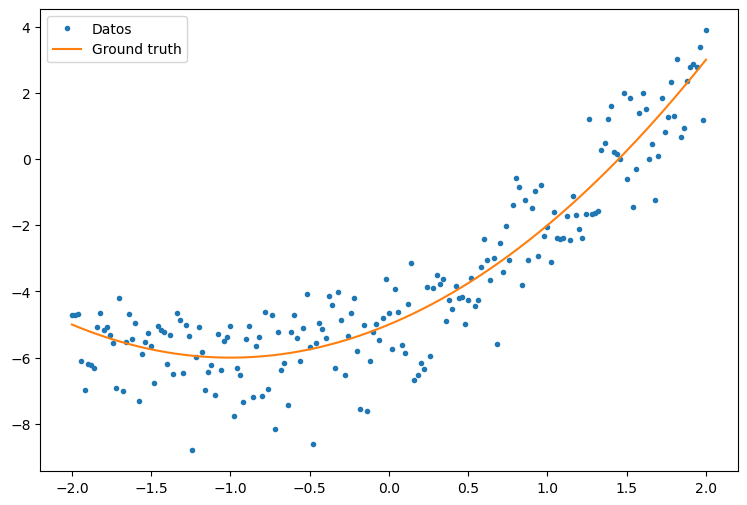

In [41]:
plt.plot(x.numpy(), y.numpy(), '.', label='Datos')
plt.plot(x, f(x), label='Ground truth')
plt.legend()

*Ground truth* significa en machine learning los valores "correctos" (la verdad de los datos).

Creamos un modelo cuadrático con pesos incializados aleatoriamente y un valor de sesgo (*bias*)

In [43]:
class Modelo(tf.Module):
    
    def __init__(self):
        rand_ini = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
        self.w_q = tf.Variable(rand_ini[0])
        self.w_l = tf.Variable(rand_ini[1])
        self.b = tf.Variable(rand_ini[2])
        
    @tf.function
    def __call__(self, x):
        return self.w_q * (x**2) + self.w_l * x + self.b

In [44]:
cuad_modelo = Modelo()

In [45]:
def plot_preds(x, y, f, modelo, titulo):
    plt.figure()
    plt.plot(x, y, '.', label='Datos')
    plt.plot(x, f(x), label='Ground truth')
    plt.plot(x, modelo(x), label='Predicciones')
    plt.title(titulo)
    plt.legend()

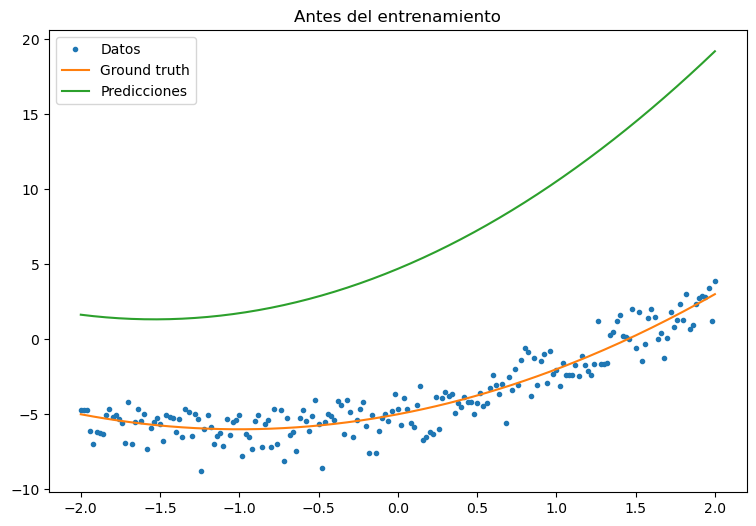

In [46]:
plot_preds(x, y, f, cuad_modelo, 'Antes del entrenamiento')

Tenemos que definir una función de coste del modelo. Usamos el error promedio cuadrado.

* Vector de predicciones: $\hat{y}$
* Vector de valores correctos: $y$

$$E = \frac{1}{m} \sum_{i=1}^m(\hat{y}_i - y_i)^2$$

In [47]:
def mse_coste(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

Escribimos un ciclo de entrenamiento del modelo. Usaremos la función de coste ya definida, y calcularemos los gradientes de esa función con respecto a los parámetros. Con esos gradientes podemos actualizar dichos parámetros.

Ocuparemos *mini-batches* (lotes pequeños) para el proceso de entrenamiento, usando la función `from_tensor_slices()`.

In [49]:
lote_tamaño = 32

In [50]:
datos = tf.data.Dataset.from_tensor_slices((x, y))

In [52]:
datos = datos.shuffle(buffer_size=x.shape[0]).batch(lote_tamaño)

In [54]:
epocas = 100
taza_aprendizaje = 0.01
coste = []

In [57]:
for epoca in range(epocas):
    for x_lote, y_lote in datos:
        
        with tf.GradientTape() as tape:
            lote_coste = mse_coste(cuad_modelo(x_lote), y_lote)
            
        grads = tape.gradient(lote_coste, cuad_modelo.variables)
        
        for g, v in zip(grads, cuad_modelo.variables):
            v.assign_sub(taza_aprendizaje*g)
            
    l = mse_coste(cuad_modelo(x), y)
    coste.append(l)
    if epoca % 10 == 0:
        print(f'Error para epoca {epoca}: {l.numpy():0.3f}')

Error para epoca 0: 55.909
Error para epoca 10: 9.994
Error para epoca 20: 4.153
Error para epoca 30: 2.138
Error para epoca 40: 1.419
Error para epoca 50: 1.173
Error para epoca 60: 1.083
Error para epoca 70: 1.050
Error para epoca 80: 1.042
Error para epoca 90: 1.039


Text(0.5, 1.0, 'Error v. iteraciones de entrenamiento')

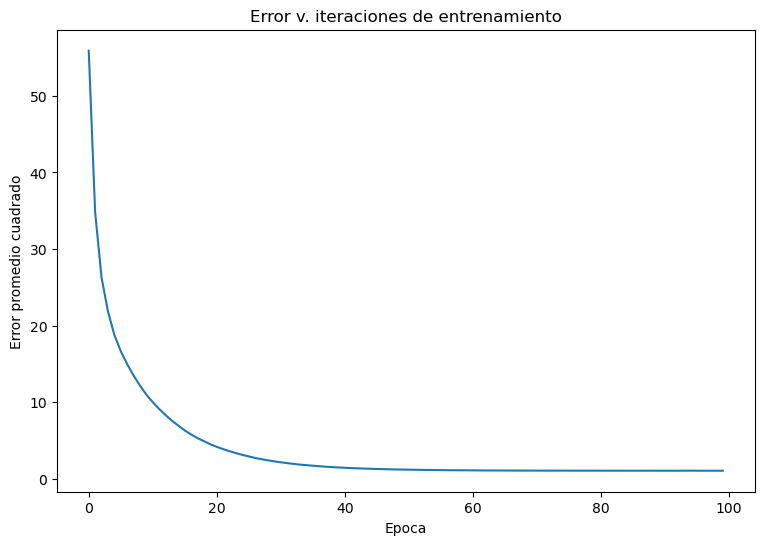

In [58]:
plt.plot(range(epocas), coste)
plt.xlabel("Epoca")
plt.ylabel("Error promedio cuadrado")
plt.title("Error v. iteraciones de entrenamiento")

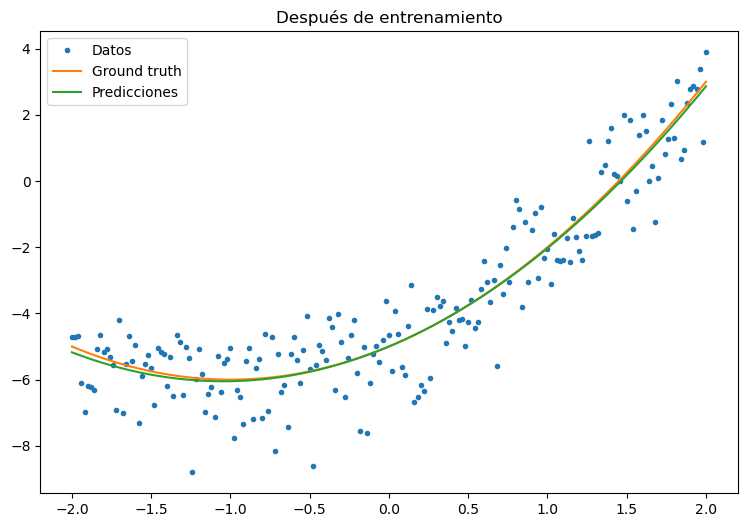

In [59]:
plot_preds(x, y, f, cuad_modelo, 'Después de entrenamiento')

Se puede usar el API de **Keras** en TensorFlow (con `tf.keras`) que tiene muchos modelos y funciones útiles. Los modelos de Keras ya tienen métodos `Model.compile` y `Model.fit` que implementan un ciclo de entrenamiento.

Vamos a crear un modelo secuencial en Keras con `tf.keras.Sequential`. Es un modelo compuesto de capas.

Una de las capas más simples es la **capa densa** (*dense layer*) que se puede instanciar con `tf.keras.layers.Dense`. Una capa así puede "aprender" una relación lineal multidimensional como $Y = WX + \vec{b}$.

Para aprender una ecuación no-lineal de la forma $w_1x^2 + w_2x + b$, la entrada a la capa densa debe ser una matriz de datos con $x^2$ y $x$ como *features*.

Una capa de tipo *lambda* (`tf.keras.layers.Lambda`) puede encargarse de la transformación de los datos.

In [60]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)
])

In [61]:
new_model.compile(loss=tf.keras.losses.MSE,
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

In [62]:
history = new_model.fit(x, y, epochs=100, batch_size=32, verbose=0)

In [63]:
new_model.save('./my_new_model')

INFO:tensorflow:Assets written to: ./my_new_model/assets


INFO:tensorflow:Assets written to: ./my_new_model/assets


Text(0.5, 1.0, 'Modelo de Keras')

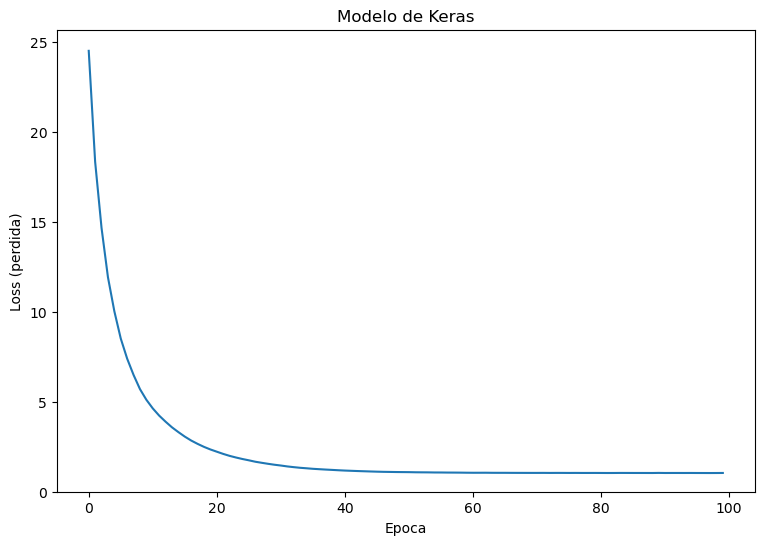

In [64]:
plt.plot(history.history['loss'])
plt.xlabel('Epoca')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss (perdida)')
plt.title('Modelo de Keras')

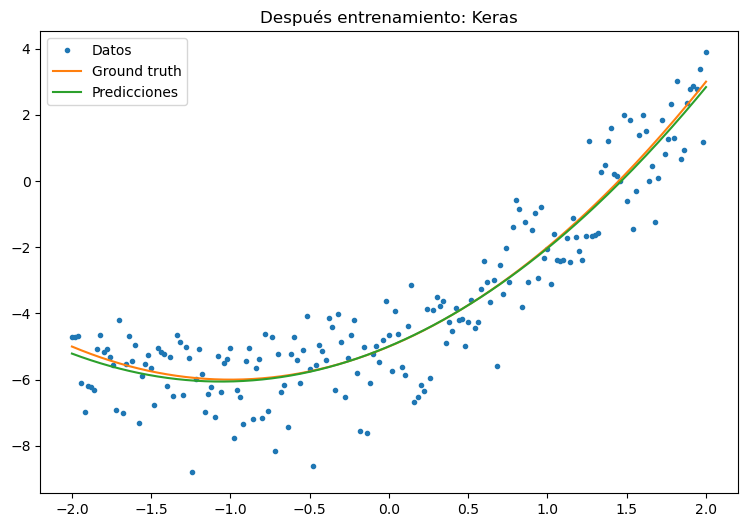

In [65]:
plot_preds(x, y, f, new_model, 'Después entrenamiento: Keras')